# AIAP Foundation Self Practice

The objective is to predict the students' O-level mathematics examination score to help the school to identify weaker students prior to the examination using the dataset provided. In your submission, you should evaluate at least 3 suitable models for estimating the students' scores.

## Data Dictionary

| Column               | Description                        |
| -------------------- | ---------------------------------- |
| student_id           | Unique ID for each student         |
| number_of_siblings   | Number of siblings                 |
| direct_admission     | Mode of entering the school        |
| CCA                  | Enrolled CCA                       |
| learning_style       | Primary learning style             |
| tuition              | Indication of whether the student has a tuition   |
| final_test           | Student's O-level mathematics examination score   |
| n_male               | Number of male classmates          |
| n_female             | Number of female classmates        |
| gender               | Gender type                        |
| age                  | Age of the student                 |
| hours_per_week       | Number of hours student studies per week          |
| attendance_rate      | Attendance rate of the student (%) |
| sleep_time           | Daily sleeping time (hour:minutes) |
| wake_time            | Daily waking up time (hour:minutes)               |
| mode_of_transport    | Mode of transport to school        |
| bag_color            | Colours of student's bag           |

<br>
<hr>

## Exploratory Data Analysis

### Load libraries

In [24]:
# Load libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
import pprint

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 999)

### Load data

In [25]:
FILE_PATH = "./data/regression_bonus_practice_data.csv"

In [26]:
try:
    df = pd.read_csv(FILE_PATH)
    print(f"Dataset loaded: {df.shape[0]:,} columns by {df.shape[1]:,} rows.")
    
except FileNotFoundError:
    print(f"File {FILE_PATH} not found. Please check the file path.")
    print("Exiting program.")
    sys.exit(1)

Dataset loaded: 15,900 columns by 18 rows.


In [27]:
display(df.head(10))

,index,number_of_siblings,direct_admission,CCA,learning_style,student_id,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport,bag_color
0,0,0,Yes,Sports,Visual,ACN2BE,Female,No,69.0,14.0,2.0,16.0,10.0,91.0,22:00,6:00,private transport,yellow
1,1,2,No,Sports,Auditory,FGXIIZ,Female,No,47.0,4.0,19.0,16.0,7.0,94.0,22:30,6:30,private transport,green
2,2,0,Yes,NaN,Visual,B9AI9F,Male,No,85.0,14.0,2.0,15.0,8.0,92.0,22:30,6:30,private transport,white
3,3,1,No,Clubs,Auditory,FEVM1T,Female,Yes,64.0,2.0,20.0,15.0,18.0,NaN,21:00,5:00,public transport,yellow
4,4,0,No,Sports,Auditory,AXZN2E,Male,No,66.0,24.0,3.0,16.0,7.0,95.0,21:30,5:30,public transport,yellow
5,5,0,No,Arts,Visual,BA6R14,Female,No,57.0,9.0,12.0,15.0,11.0,96.0,22:30,6:30,private transport,red
6,6,2,Yes,NaN,Visual,D5WGTI,Male,No,69.0,12.0,3.0,16.0,15.0,93.0,21:30,5:30,public transport,green
7,7,0,No,Sports,Visual,HTP8CW,Male,No,76.0,20.0,2.0,15.0,3.0,97.0,21:00,5:00,public transport,green
8,8,0,No,Arts,Auditory,U3YRTC,Male,No,57.0,20.0,7.0,15.0,15.0,98.0,22:00,6:00,private transport,red
9,9,2,No,Arts,Auditory,3MOMA6,Male,Yes,60.0,13.0,9.0,16.0,16.0,NaN,22:30,6:30,private transport,green


### Checking dataset structure

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15900 entries, 0 to 15899
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               15900 non-null  int64  
 1   number_of_siblings  15900 non-null  int64  
 2   direct_admission    15900 non-null  object 
 3   CCA                 12071 non-null  object 
 4   learning_style      15900 non-null  object 
 5   student_id          15900 non-null  object 
 6   gender              15900 non-null  object 
 7   tuition             15900 non-null  object 
 8   final_test          15405 non-null  float64
 9   n_male              15900 non-null  float64
 10  n_female            15900 non-null  float64
 11  age                 15900 non-null  float64
 12  hours_per_week      15900 non-null  float64
 13  attendance_rate     15122 non-null  float64
 14  sleep_time          15900 non-null  object 
 15  wake_time           15900 non-null  object 
 16  mode

### Checking for missing values

In [29]:
# Identify columns with missing data
missing_counts = df.isnull().sum()
missing_percent = df.isnull().mean() * 100

# Filter columns with missing values
missing_columns = missing_counts[missing_counts > 0].index.tolist()

# Display columns with missing values, their count, and percentage
print("Columns with missing data:\n")
for col in missing_columns:
    print(
        f"{col:<25} : {missing_counts[col]:>6,} missing ({missing_percent[col]:>5.2f}%)")

Columns with missing data:

CCA                       :  3,829 missing (24.08%)
final_test                :    495 missing ( 3.11%)
attendance_rate           :    778 missing ( 4.89%)


### Checking numerical columns statistics

In [30]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
index,15900.0,7949.500000,4590.078975,0.0,3974.75,7949.5,11924.25,15899.0
number_of_siblings,15900.0,0.886541,0.751346,0.0,0.00,1.0,1.00,2.0
final_test,15405.0,67.165401,13.977879,32.0,56.00,68.0,78.00,100.0
n_male,15900.0,13.880000,6.552584,0.0,10.00,14.0,18.00,31.0
n_female,15900.0,8.906038,6.663852,0.0,4.00,8.0,13.00,31.0
age,15900.0,15.213459,1.758941,-5.0,15.00,15.0,16.00,16.0
hours_per_week,15900.0,10.312579,4.461861,0.0,7.00,9.0,14.00,20.0
attendance_rate,15122.0,93.270268,7.984230,40.0,92.00,95.0,97.00,100.0


### Checking for duplicates

In [31]:
df.duplicated().sum()

np.int64(0)

### Checking non-numerical columns

In [32]:
# df.select_dtypes(include = 'object').value_counts()
value_counts_dict = {col: df[col].value_counts() for col in df.select_dtypes(include='object').columns}

pprint.pprint(value_counts_dict)


{'CCA': CCA
Clubs     3912
Sports    3865
Arts      3785
CLUBS      143
NONE       130
ARTS       128
SPORTS     108
Name: count, dtype: int64,
 'bag_color': bag_color
yellow    2731
green     2653
black     2650
blue      2634
red       2620
white     2612
Name: count, dtype: int64,
 'direct_admission': direct_admission
No     11195
Yes     4705
Name: count, dtype: int64,
 'gender': gender
Male      7984
Female    7916
Name: count, dtype: int64,
 'learning_style': learning_style
Auditory    9132
Visual      6768
Name: count, dtype: int64,
 'mode_of_transport': mode_of_transport
public transport     6371
private transport    6323
walk                 3206
Name: count, dtype: int64,
 'sleep_time': sleep_time
23:00    3131
22:00    3067
22:30    3034
21:00    2953
21:30    2875
0:00      240
23:30     183
1:00      122
0:30       93
2:00       81
1:30       73
2:30       25
3:00       23
Name: count, dtype: int64,
 'student_id': student_id
GD80JW    2
41XMCC    2
AJRPSG    2
72KRUA    2


### Creating a copy of dataset before cleaning data

In [33]:
df_copy = df.copy(deep = True)

## Data Cleaning

### Cleaning `CCA` column

In [34]:
df['CCA'].value_counts()

CCA
Clubs     3912
Sports    3865
Arts      3785
CLUBS      143
NONE       130
ARTS       128
SPORTS     108
Name: count, dtype: int64

### Creating sleep duration column

In [35]:
# 2. Convert string columns to datetime objects
# We only care about the time, but converting to full datetime makes calculations easy
df['sleep_time_dt'] = pd.to_datetime(df['sleep_time'], format='%H:%M')
df['wake_time_dt'] = pd.to_datetime(df['wake_time'], format='%H:%M')


# 3. Calculate the duration, handling the overnight case
# np.where(condition, value_if_true, value_if_false)
duration = np.where(
    df['wake_time_dt'] < df['sleep_time_dt'],
    # If wake time is "before" sleep time, add a day to wake time
    df['wake_time_dt'] + pd.Timedelta(days=1) - df['sleep_time_dt'],
    # Otherwise, it's a simple subtraction
    df['wake_time_dt'] - df['sleep_time_dt']
)
df['sleep_duration'] = duration


# 4. Convert the duration (Timedelta) to total minutes
df['sleep_minutes'] = (df['sleep_duration'].dt.total_seconds() / 60).astype(int)

df['sleep_minutes'].describe()

count    15900.000000
mean       470.788679
std         36.140028
min        240.000000
25%        480.000000
50%        480.000000
75%        480.000000
max        480.000000
Name: sleep_minutes, dtype: float64

In [36]:
df.head()

,index,number_of_siblings,direct_admission,CCA,learning_style,student_id,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport,bag_color,sleep_time_dt,wake_time_dt,sleep_duration,sleep_minutes
0,0,0,Yes,Sports,Visual,ACN2BE,Female,No,69.0,14.0,2.0,16.0,10.0,91.0,22:00,6:00,private transport,yellow,1900-01-01 22:00:00,1900-01-01 06:00:00,0 days 08:00:00,480
1,1,2,No,Sports,Auditory,FGXIIZ,Female,No,47.0,4.0,19.0,16.0,7.0,94.0,22:30,6:30,private transport,green,1900-01-01 22:30:00,1900-01-01 06:30:00,0 days 08:00:00,480
2,2,0,Yes,NaN,Visual,B9AI9F,Male,No,85.0,14.0,2.0,15.0,8.0,92.0,22:30,6:30,private transport,white,1900-01-01 22:30:00,1900-01-01 06:30:00,0 days 08:00:00,480
3,3,1,No,Clubs,Auditory,FEVM1T,Female,Yes,64.0,2.0,20.0,15.0,18.0,NaN,21:00,5:00,public transport,yellow,1900-01-01 21:00:00,1900-01-01 05:00:00,0 days 08:00:00,480
4,4,0,No,Sports,Auditory,AXZN2E,Male,No,66.0,24.0,3.0,16.0,7.0,95.0,21:30,5:30,public transport,yellow,1900-01-01 21:30:00,1900-01-01 05:30:00,0 days 08:00:00,480


### Cleaning `tuition` column

In [37]:
df['tuition'].value_counts()

tuition
Yes    8669
No     6643
Y       327
N       261
Name: count, dtype: int64

In [38]:
tuition_replacement_code = {'Yes': 'Y', 
                            'No': 'N'
                            }
df['tuition'] = df['tuition'].replace(tuition_replacement_code)

df['tuition'].value_counts()

tuition
Y    8996
N    6904
Name: count, dtype: int64

### Filling up missing values in `attendance_rate`

In [39]:
df['attendance_rate'].describe()

count    15122.000000
mean        93.270268
std          7.984230
min         40.000000
25%         92.000000
50%         95.000000
75%         97.000000
max        100.000000
Name: attendance_rate, dtype: float64

In [40]:
df['attendance_rate'] = df['attendance_rate'].ffill()

df['attendance_rate'].describe()

count    15900.000000
mean        93.242956
std          8.037424
min         40.000000
25%         92.000000
50%         95.000000
75%         97.000000
max        100.000000
Name: attendance_rate, dtype: float64

### Cleaning `CCA` column

In [41]:
df['CCA'] = df['CCA'].str.upper()

df['CCA'].fillna('NONE', inplace = True)

df['CCA'].value_counts()

CCA
CLUBS     4055
SPORTS    3973
NONE      3959
ARTS      3913
Name: count, dtype: int64

In [42]:
df.head(10)

,index,number_of_siblings,direct_admission,CCA,learning_style,student_id,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport,bag_color,sleep_time_dt,wake_time_dt,sleep_duration,sleep_minutes
0,0,0,Yes,SPORTS,Visual,ACN2BE,Female,N,69.0,14.0,2.0,16.0,10.0,91.0,22:00,6:00,private transport,yellow,1900-01-01 22:00:00,1900-01-01 06:00:00,0 days 08:00:00,480
1,1,2,No,SPORTS,Auditory,FGXIIZ,Female,N,47.0,4.0,19.0,16.0,7.0,94.0,22:30,6:30,private transport,green,1900-01-01 22:30:00,1900-01-01 06:30:00,0 days 08:00:00,480
2,2,0,Yes,NONE,Visual,B9AI9F,Male,N,85.0,14.0,2.0,15.0,8.0,92.0,22:30,6:30,private transport,white,1900-01-01 22:30:00,1900-01-01 06:30:00,0 days 08:00:00,480
3,3,1,No,CLUBS,Auditory,FEVM1T,Female,Y,64.0,2.0,20.0,15.0,18.0,92.0,21:00,5:00,public transport,yellow,1900-01-01 21:00:00,1900-01-01 05:00:00,0 days 08:00:00,480
4,4,0,No,SPORTS,Auditory,AXZN2E,Male,N,66.0,24.0,3.0,16.0,7.0,95.0,21:30,5:30,public transport,yellow,1900-01-01 21:30:00,1900-01-01 05:30:00,0 days 08:00:00,480
5,5,0,No,ARTS,Visual,BA6R14,Female,N,57.0,9.0,12.0,15.0,11.0,96.0,22:30,6:30,private transport,red,1900-01-01 22:30:00,1900-01-01 06:30:00,0 days 08:00:00,480
6,6,2,Yes,NONE,Visual,D5WGTI,Male,N,69.0,12.0,3.0,16.0,15.0,93.0,21:30,5:30,public transport,green,1900-01-01 21:30:00,1900-01-01 05:30:00,0 days 08:00:00,480
7,7,0,No,SPORTS,Visual,HTP8CW,Male,N,76.0,20.0,2.0,15.0,3.0,97.0,21:00,5:00,public transport,green,1900-01-01 21:00:00,1900-01-01 05:00:00,0 days 08:00:00,480
8,8,0,No,ARTS,Auditory,U3YRTC,Male,N,57.0,20.0,7.0,15.0,15.0,98.0,22:00,6:00,private transport,red,1900-01-01 22:00:00,1900-01-01 06:00:00,0 days 08:00:00,480
9,9,2,No,ARTS,Auditory,3MOMA6,Male,Y,60.0,13.0,9.0,16.0,16.0,98.0,22:30,6:30,private transport,green,1900-01-01 22:30:00,1900-01-01 06:30:00,0 days 08:00:00,480


In [43]:
df.isnull().sum()

index                   0
number_of_siblings      0
direct_admission        0
CCA                     0
learning_style          0
student_id              0
gender                  0
tuition                 0
final_test            495
n_male                  0
n_female                0
age                     0
hours_per_week          0
attendance_rate         0
sleep_time              0
wake_time               0
mode_of_transport       0
bag_color               0
sleep_time_dt           0
wake_time_dt            0
sleep_duration          0
sleep_minutes           0
dtype: int64

### Saving a cleaned copy and removing observationss with no `final_test` values

In [44]:
df_null_score = df[df['final_test'].isnull()]

df.dropna(inplace = True)

df_cleaned = df.copy(deep = True)

df.drop(columns = ['index', 'student_id', 'sleep_time', 'wake_time', 'sleep_time_dt', 'wake_time_dt', 'sleep_duration'],
        inplace = True)

### Checking cleaned data structure

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15405 entries, 0 to 15899
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   number_of_siblings  15405 non-null  int64  
 1   direct_admission    15405 non-null  object 
 2   CCA                 15405 non-null  object 
 3   learning_style      15405 non-null  object 
 4   gender              15405 non-null  object 
 5   tuition             15405 non-null  object 
 6   final_test          15405 non-null  float64
 7   n_male              15405 non-null  float64
 8   n_female            15405 non-null  float64
 9   age                 15405 non-null  float64
 10  hours_per_week      15405 non-null  float64
 11  attendance_rate     15405 non-null  float64
 12  mode_of_transport   15405 non-null  object 
 13  bag_color           15405 non-null  object 
 14  sleep_minutes       15405 non-null  int64  
dtypes: float64(6), int64(2), object(7)
memory usage: 1.9+ MB


In [46]:
df.duplicated().sum()

np.int64(142)

## Univariate analysis

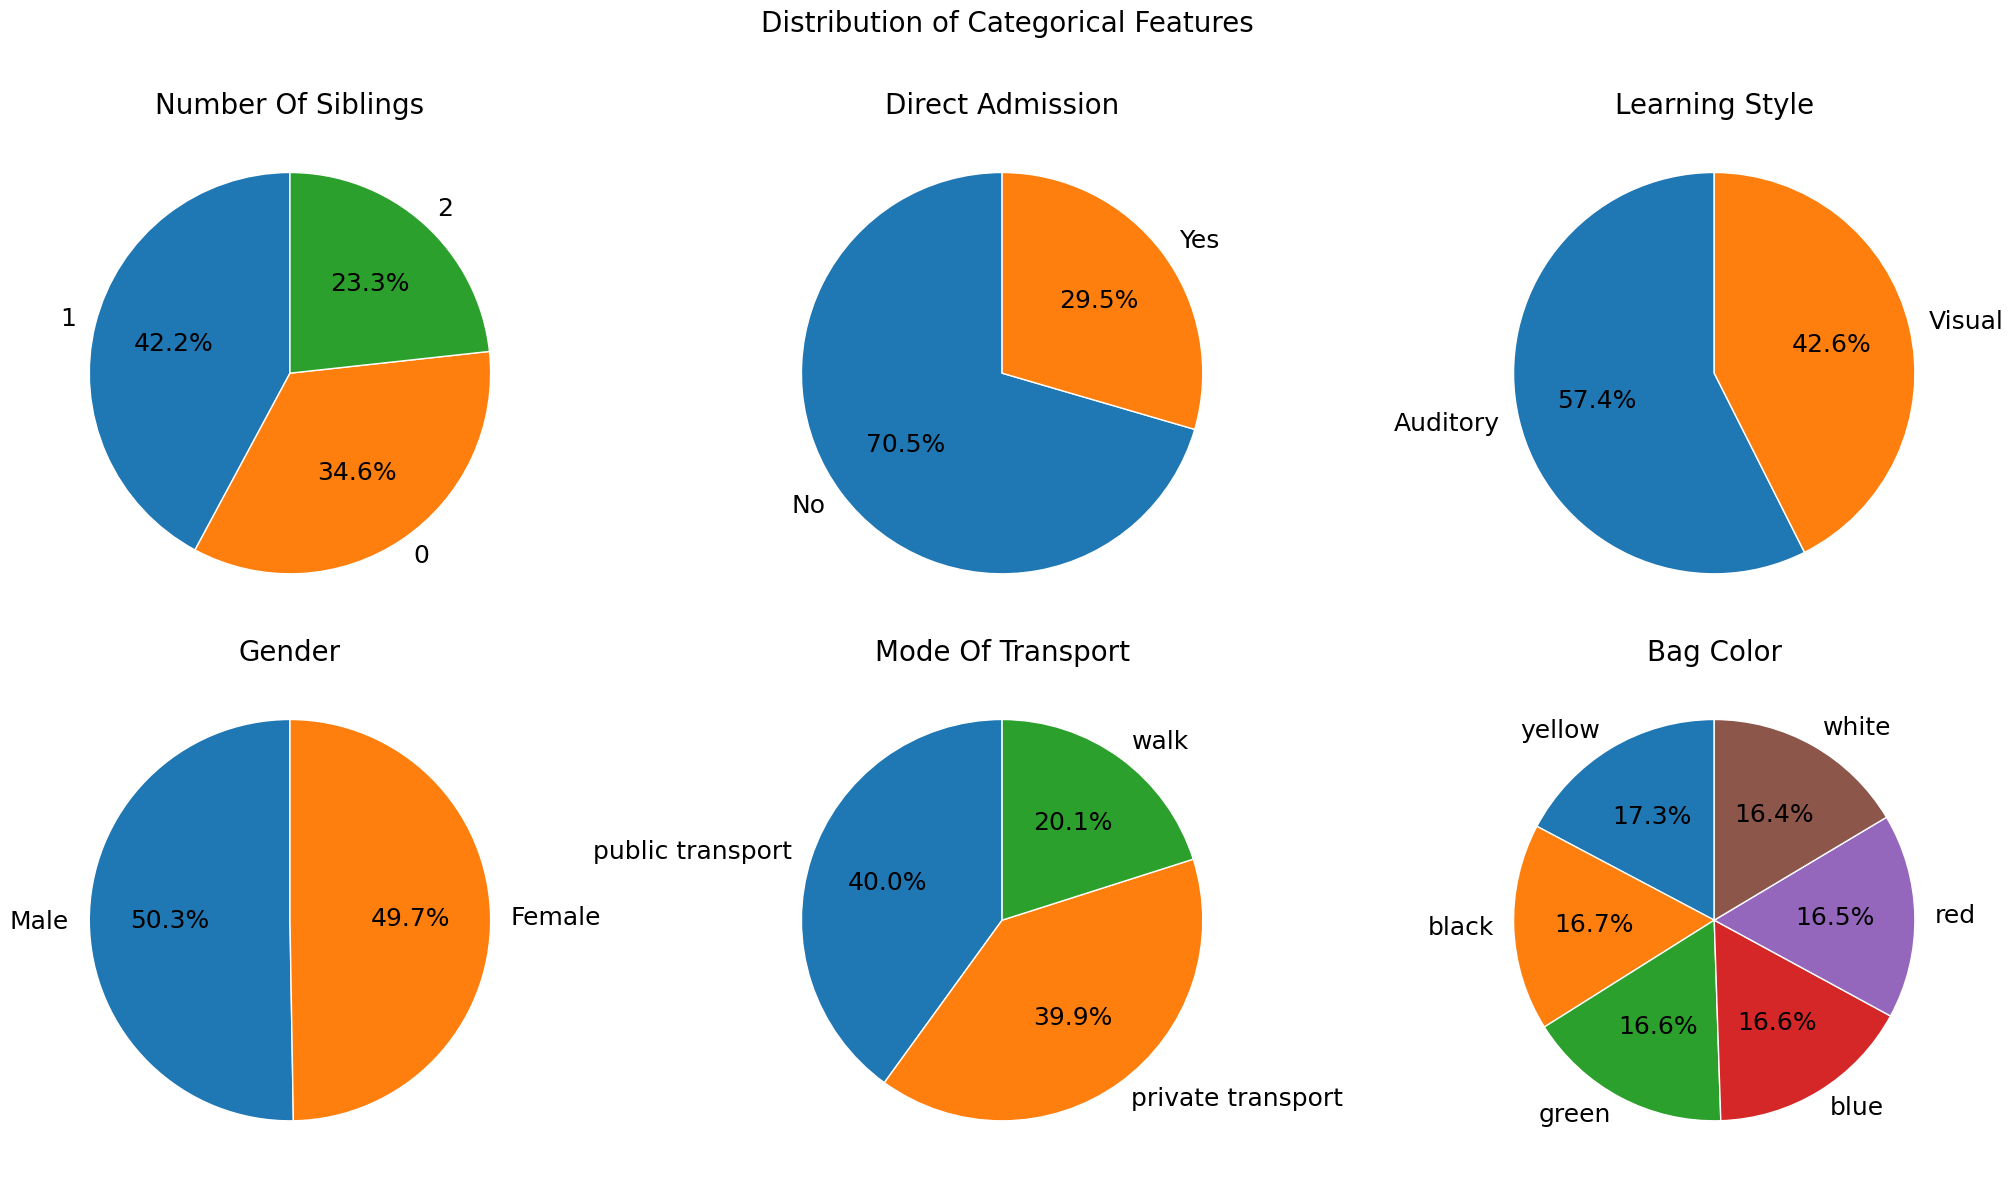

In [56]:
# 2. List of columns
columns_to_plot = [
    'number_of_siblings', 'direct_admission', 'learning_style', 
    'gender', 'mode_of_transport', 'bag_color'
]

# 3. Create a figure and a set of subplots
# We have 6 columns, so a 2x3 grid is perfect.
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
fig.suptitle('Distribution of Categorical Features', fontsize=20)

# Flatten the axes array to make it easy to loop over
axes = axes.flatten()

# 4. Loop through columns and plot on each subplot
for i, column in enumerate(columns_to_plot):
    value_counts = df[column].value_counts()
    ax = axes[i] # Select the subplot
    
    ax.pie(
        value_counts, 
        labels=value_counts.index, 
        autopct='%1.1f%%', 
        startangle=90,
        # Add some styling for a cleaner look
        wedgeprops={'edgecolor': 'white'},
        textprops={'fontsize': 18} 
    )
    ax.set_title(f'{column.replace("_", " ").title()}', fontsize = 20)

# If you have an odd number of plots, you might want to hide the last empty one
# for i in range(len(columns_to_plot), len(axes)):
#     fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for the suptitle
plt.show()


### Histogram of `CCA`

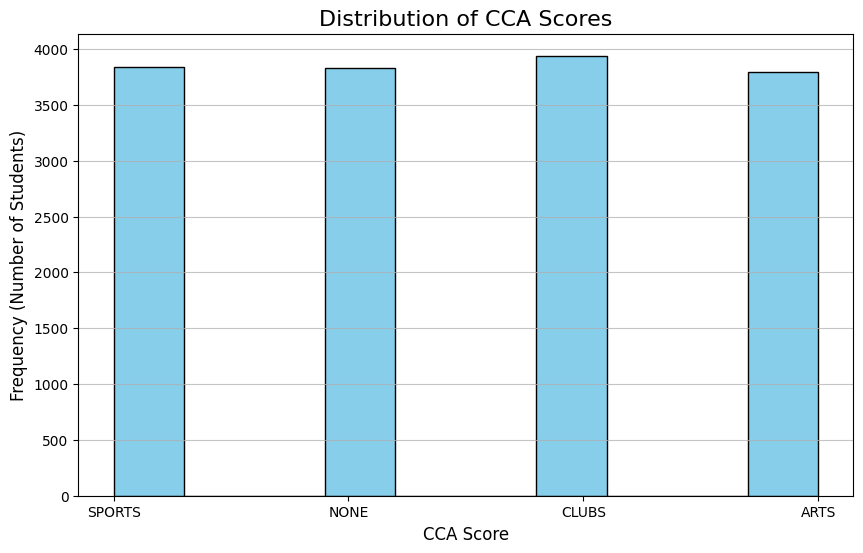

In [54]:
# 2. Create the histogram using Matplotlib
plt.figure(figsize=(10, 6)) # Set the figure size for better readability

plt.hist(
    df['CCA'], 
    bins=10,          # You can adjust the number of bins to see more or less detail
    color='skyblue',  # Set the color of the bars
    edgecolor='black' # Add black edges to bars for better separation
)

# 3. Add labels and a title for clarity
plt.title('Distribution of CCA Scores', fontsize=16)
plt.xlabel('CCA Score', fontsize=12)
plt.ylabel('Frequency (Number of Students)', fontsize=12)
plt.grid(axis='y', alpha=0.75) # Add a grid for the y-axis

# 4. Display the plot
plt.show()
